# 25-D Correlated Normal

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems (with or without the use of gradients). Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems using a 25-D correlated multivariate normal distribution.

In [4]:
ndim = 25  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.4  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# gradient of log-likelihood *with respect to u*
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 10.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-57.56461299227203


Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                nlive=500, bound='single', 
                                sample='slice', slices=5, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res = sampler.results

20653it [04:30, 76.41it/s, +500 | bound: 217 | nc: 1 | ncall: 12337157 | eff(%):  0.171 | loglstar:   -inf < -20.746 <    inf | logz: -57.408 +/-  0.233 | dlogz:  0.000 >  0.010]


In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single', 
                                sample='rslice', slices=25,
                                rstate=rstate)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

20510it [01:11, 285.49it/s, +500 | bound: 98 | nc: 1 | ncall: 2474521 | eff(%):  0.849 | loglstar:   -inf < -20.662 <    inf | logz: -57.038 +/-  0.231 | dlogz:  0.000 >  0.010]


In [7]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single',
                                sample='hslice', slices=5,
                                gradient=gradient, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res3 = sampler.results

20617it [05:52, 58.52it/s, +500 | bound: 206 | nc: 1 | ncall: 12988536 | eff(%):  0.163 | loglstar:   -inf < -21.094 <    inf | logz: -57.684 +/-  0.233 | dlogz:  0.000 >  0.010]


Now let's see how we do.

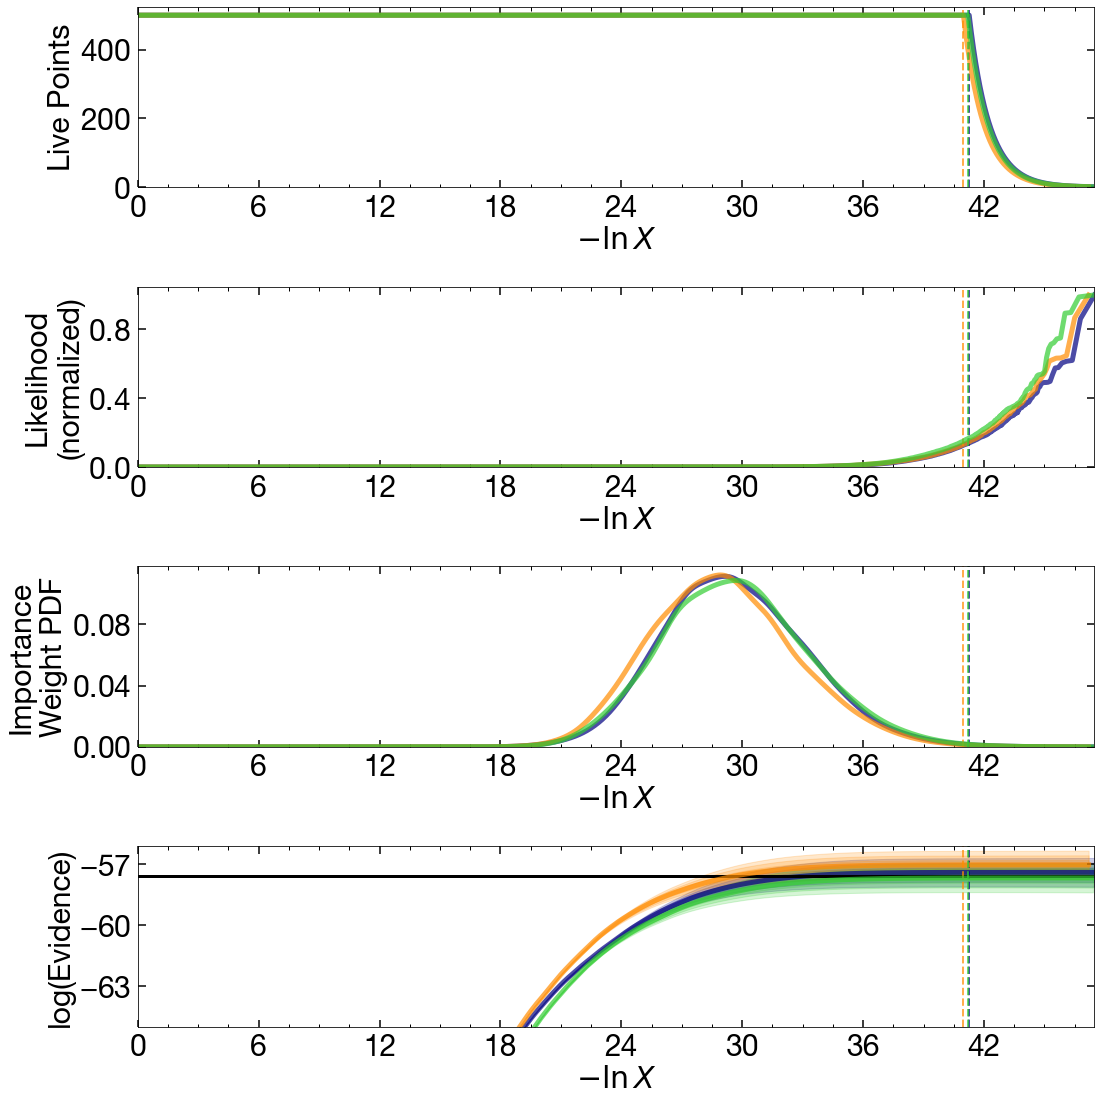

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='navy', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='darkorange', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()

In [9]:
from dynesty import utils as dyfunc

print('Mean:')
print('slice:', dyfunc.mean_and_cov(res.samples, 
                                    np.exp(res.logwt-res.logz[-1]))[0])
print('rslice:', dyfunc.mean_and_cov(res2.samples, 
                                     np.exp(res2.logwt-res2.logz[-1]))[0])
print('hslice:', dyfunc.mean_and_cov(res3.samples, 
                                     np.exp(res3.logwt-res3.logz[-1]))[0])

print('\nVariance:')
print('slice:', np.diagonal(dyfunc.mean_and_cov(res.samples, 
                                                np.exp(res.logwt-res.logz[-1]))[1]))
print('rslice:', np.diagonal(dyfunc.mean_and_cov(res2.samples, 
                                                 np.exp(res2.logwt-res2.logz[-1]))[1]))
print('hslice:', np.diagonal(dyfunc.mean_and_cov(res3.samples, 
                                                 np.exp(res3.logwt-res3.logz[-1]))[1]))

Mean:
slice: [ 1.40352270e-02 -1.31906108e-03  7.45649643e-03 -8.78006483e-04
  1.56527640e-02 -1.84804393e-02  2.09725236e-02 -1.01427130e-05
  4.56904086e-03 -8.25959648e-03 -4.65726135e-03  1.77317372e-04
  9.52610232e-03  2.22235937e-02  1.72859594e-03 -1.59573021e-02
  8.45422947e-03 -1.36954579e-02  2.36103829e-04  1.45150468e-02
  4.81558278e-03  4.35512224e-03  1.33838451e-03  1.77488784e-02
 -2.64142113e-03]
rslice: [ 0.02395383  0.00591787 -0.0081816   0.01474126  0.0145016   0.02227915
  0.00128397  0.01019611  0.02057033  0.0171686  -0.03116933  0.01173736
  0.01047237  0.00340197  0.01289436  0.00493727 -0.00608506  0.0326279
  0.02479344  0.00570989 -0.01116066  0.02458587  0.00373277  0.01568896
  0.01417945]
hslice: [ 1.58445498e-02  4.01185967e-03 -9.00921208e-03  7.74000032e-03
  4.74700729e-03  6.77714757e-03  2.30046793e-03 -8.02371338e-03
  1.03059116e-02 -3.68285799e-03 -4.47570755e-04  4.54339935e-03
 -5.30174832e-03 -7.75066055e-03 -1.70955057e-03 -1.36556538e-0